### This is for the Analysis for Bias Adjusted Precipitation data of CMIP6 GCMs

In [25]:
import xarray as xr
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
import numpy as np
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
from esda.moran import Moran
from libpysal.weights import KNN
from eval.metrics import *
from eval.plot import *
import data.valid_crd as valid_crd
import glob
import os
import yaml

In [17]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors

# # Open the dataset
# ds_sample = xr.open_dataset("/pscratch/sd/k/kas7897/cmip6/mri_esm2_0/landcover.nc")

# # Define 19 distinct colors
# colors = [
#     "#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99", 
#     "#e31a1c", "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a", 
#     "#ffff99", "#b15928", "#8dd3c7", "#ffffb3", "#bebada", 
#     "#fb8072", "#80b1d3", "#fdb462", "#b3de69"
# ]

# # Create a listed colormap for the 19 categories
# cmap = mcolors.ListedColormap(colors, name='landcover_cmap')

# # Plot with the custom colormap
# ds_sample['landcover'].plot(cmap=cmap)
# plt.title("Landcover Categories (1-19)")
# plt.show()

In [18]:

def load_run_path(run_id, base_dir='/pscratch/sd/k/kas7897/diffDownscale/jobs/'):
    # Find path for run_id
    pattern = os.path.join(base_dir, '*', '*', run_id)  # Wildcard to match structure
    matching_dirs = glob.glob(pattern)
    
    if not matching_dirs:
        raise FileNotFoundError(f"No directory found for run_id {run_id}")
    if len(matching_dirs) > 1:
        raise ValueError(f"Multiple directories found for run_id {run_id}, please resolve ambiguity:\n{matching_dirs}")
    
    run_path = matching_dirs[0]


    return run_path


In [80]:
run_id = 'c2cb1845'
train_period = [1979,2000]
test_period = [1979,2000]
testep = 100
run_path = load_run_path(run_id)
# Load files from the discovered directory
x = torch.load(os.path.join(run_path, f'{train_period[0]}_{train_period[1]}', f'{test_period[0]}_{test_period[1]}', 'x.pt'), map_location='cpu').to('cpu').squeeze(-1).numpy()
y = torch.load(os.path.join(run_path, f'{train_period[0]}_{train_period[1]}', f'{test_period[0]}_{test_period[1]}', 'y.pt'), map_location='cpu').to('cpu').squeeze(-1).numpy()
time = torch.load(os.path.join(run_path, f'{train_period[0]}_{train_period[1]}', f'{test_period[0]}_{test_period[1]}', 'time.pt'), map_location='cpu')

xt = torch.load(os.path.join(run_path, f'{train_period[0]}_{train_period[1]}', f'{test_period[0]}_{test_period[1]}', f'ep{testep}', 'xt.pt'),  map_location='cpu')


# Load the config.yaml file
with open(os.path.join(run_path, f'{train_period[0]}_{train_period[1]}', 'train_config.yaml'), 'r') as f:
    config = yaml.safe_load(f)

clim = config['clim']
ref = config['ref']
time_scale = config['time_scale']
emph_quantile = config['emph_quantile']
degree = config['degree']

ref_path = config['ref_dir']

In [81]:
run_id1 = 'a8268a40'
testep1 = 50
run_path1 = load_run_path(run_id1)
# Load files from the discovered directory
x1 = torch.load(os.path.join(run_path1, f'{train_period[0]}_{train_period[1]}', f'{test_period[0]}_{test_period[1]}', 'x.pt'), map_location='cpu').to('cpu').squeeze(-1).numpy()
y1 = torch.load(os.path.join(run_path1, f'{train_period[0]}_{train_period[1]}', f'{test_period[0]}_{test_period[1]}', 'y.pt'), map_location='cpu').to('cpu').squeeze(-1).numpy()
time1 = torch.load(os.path.join(run_path1, f'{train_period[0]}_{train_period[1]}', f'{test_period[0]}_{test_period[1]}', 'time.pt'), map_location='cpu')

xt1 = torch.load(os.path.join(run_path1, f'{train_period[0]}_{train_period[1]}', f'{test_period[0]}_{test_period[1]}', f'ep{testep1}', 'xt.pt'),  map_location='cpu')


# Load the config.yaml file
with open(os.path.join(run_path1, f'{train_period[0]}_{train_period[1]}', 'train_config.yaml'), 'r') as f:
    config1 = yaml.safe_load(f)

ref1 = config1['ref']
time_scale1 = config1['time_scale']
emph_quantile1 = config1['emph_quantile']
degree1 = config1['degree']

In [82]:
ds_sample = xr.open_dataset(f"{ref_path}/prec/{clim}/prec.1980.nc")
valid_coords = valid_crd.valid_lat_lon(ds_sample, var_name='prec', shapefile_path='/pscratch/sd/k/kas7897/us_huc/contents/WBDHU2.shp', attrList=[14, 15, 16, 17, 18])

In [83]:
# # Define start and end date
# clim = 'access_cm2'
# ref = 'livneh'
# start_date = "1981-01-01"
# end_date = "1995-12-31"
# period = [1981, 1995]
# degree = 1
# testep = 200
# emph_quantile = 0.5
# scale = 'daily'

# cmip6_dir = '/pscratch/sd/k/kas7897/cmip6'
# ref_path = '/pscratch/sd/k/kas7897/Livneh/unsplit/'
# if clim ==  'ensemble':
#     y_clim = 'access_cm2'
# else:
#     y_clim = clim

# ds_sample = xr.open_dataset(f"{ref_path}/precipitation/{y_clim}/prec.1980.nc")
# valid_coords = valid_crd.valid_lat_lon(ds_sample)


# y = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-{ref}/QM_ANN_layers4_degree{degree}_quantile{emph_quantile}_scale{scale}/all/1950_1980/{period[0]}_{period[1]}/y.pt', weights_only = False,  map_location='cpu').to('cpu').squeeze(-1).numpy()
# x = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-{ref}/QM_ANN_layers4_degree{degree}_quantile{emph_quantile}_scale{scale}/all/1950_1980/{period[0]}_{period[1]}/x.pt', weights_only = False,  map_location='cpu').to('cpu').squeeze(-1).numpy()
# time = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-{ref}/QM_ANN_layers4_degree{degree}_quantile{emph_quantile}_scale{scale}/all/1950_1980/{period[0]}_{period[1]}/time.pt', weights_only = False)


# xt = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-{ref}/QM_ANN_layers4_degree{degree}_quantile{emph_quantile}_scale{scale}/all/1950_1980/{period[0]}_{period[1]}/ep{testep}/xt.pt', weights_only = False, map_location='cpu')
# # xt = xr.open_dataset(f'/pscratch/sd/k/kas7897/cmip6/ensemble/1950_1980/{period[0]}_{period[1]}/diffDownscale/precipitation/ensemble.nc')
# # xt = xt['pr'].sel(lat=xr.DataArray(valid_coords[:, 0], dims='points'),
# #                                     lon=xr.DataArray(valid_coords[:, 1], dims='points'),
# #                                     method='nearest').values




In [84]:
# # Define start and end date
# clim = 'access_cm2'
# ref = 'gridmet'
# train_period = [1979,2000]
# # start_date = "1981-01-01"
# # end_date = "1995-12-31"
# test_period = [2000, 2014]
# degree = 1
# testep = 50
# emph_quantile = 0.5
# scale = 'daily'

# cmip6_dir = '/pscratch/sd/k/kas7897/cmip6'
# ref_path = '/pscratch/sd/k/kas7897/gridmet/'
# if clim ==  'ensemble':
#     y_clim = 'access_cm2'
# else:
#     y_clim = clim

# ds_sample = xr.open_dataset(f"{ref_path}/precipitation_amount/{y_clim}/prec.1980.nc")
# valid_coords = valid_crd.valid_lat_lon(ds_sample)


# y = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-{ref}/QM_ANN_layers4_degree{degree}_quantile{emph_quantile}_scale{scale}/{run_id}/{train_period[0]}_{train_period[1]}/{test_period[0]}_{test_period[1]}/y.pt', weights_only = False,  map_location='cpu').to('cpu').squeeze(-1).numpy()
# x = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-{ref}/QM_ANN_layers4_degree{degree}_quantile{emph_quantile}_scale{scale}/{run_id}/{train_period[0]}_{train_period[1]}/{test_period[0]}_{test_period[1]}/x.pt', weights_only = False,  map_location='cpu').to('cpu').squeeze(-1).numpy()
# time = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-{ref}/QM_ANN_layers4_degree{degree}_quantile{emph_quantile}_scale{scale}/{run_id}/{train_period[0]}_{train_period[1]}/{test_period[0]}_{test_period[1]}/time.pt', weights_only = False)


# xt = torch.load(f'/pscratch/sd/k/kas7897/diffDownscale/jobs/{clim}-{ref}/QM_ANN_layers4_degree{degree}_quantile{emph_quantile}_scale{scale}/{run_id}/{train_period[0]}_{train_period[1]}/{period[0]}_{period[1]}/ep{testep}/xt.pt', weights_only = False, map_location='cpu')
# # xt = xr.open_dataset(f'/pscratch/sd/k/kas7897/cmip6/ensemble/1950_1980/{period[0]}_{period[1]}/diffDownscale/precipitation/ensemble.nc')
# # xt = xt['pr'].sel(lat=xr.DataArray(valid_coords[:, 0], dims='points'),
# #                                     lon=xr.DataArray(valid_coords[:, 1], dims='points'),
# #                                     method='nearest').values

In [85]:

## Loading competitors

cmip6_dir = '/pscratch/sd/k/kas7897/cmip6'
loca = xr.open_dataset(f'{cmip6_dir}/{clim}/historical/precipitation/loca/coarse_USclip.nc')
loca = loca['pr'].sel(lat=xr.DataArray(valid_coords[:, 0], dims='points'),
                                    lon=xr.DataArray(valid_coords[:, 1], dims='points'),
                                    method='nearest')
loca = loca.sel(time =slice(f'{test_period[0]}', f'{test_period[1]}')).values

#unit conversion
loca = loca*86400





# QM_bench = f'benchmark/QuantileMapping/conus/{clim}-{ref}/{train_period}_historical_{test_period}.pt'
# QM_debiased = torch.load(QM_bench, weights_only=False).squeeze(-1)
# QM_debiased = QM_debiased*86400

In [86]:
## this block filters 'y' based on 'x' calender

x_time_np = np.array([pd.Timestamp(str(t)) for t in time])
x_time_np = np.array([pd.Timestamp(t).replace(hour=0, minute=0, second=0) for t in x_time_np], dtype='datetime64[D]')
# Generate a daily time array following the standard Gregorian calendar
y_time = pd.date_range(start=f"{test_period[0]}-01-01", end=f"{test_period[1]}-12-31", freq="D")

# Convert to NumPy array for indexing and comparison
y_time_np = y_time.to_numpy()

# Find indices where observed time matches model time
matched_indices = np.where(np.isin(y_time_np, x_time_np))[0]

y = y[matched_indices,:]
y1 = y1[matched_indices,:]

# loca = loca[matched_indices, :]

### Season Filtering

In [87]:
# y_s = load_seasonal_data(x_time_np, y)
# x_s = load_seasonal_data(x_time_np, x)
# xt_s = load_seasonal_data(x_time_np, xt)

# loca_s = load_seasonal_data(x_time_np, loca)
# # QM_s = load_seasonal_data(x_time_np, QM_debiased)


# t_s = load_seasonal_data(x_time_np, x_time_np)

In [90]:

# Initialize climate indices manager
climate_indices = ClimateIndices()

day_bias_percentages = get_day_bias_percentages(x, y, xt, climate_indices)
mean_bias_percentages = get_mean_bias_percentages(x, y, xt, x_time_np, climate_indices)


day_bias_percentages1 = get_day_bias_percentages(x1, y1, xt1, climate_indices)
mean_bias_percentages1 = get_mean_bias_percentages(x1, y1, xt1, x_time_np, climate_indices)

loca_day_bias_percentages = get_day_bias_percentages(x, y, loca, climate_indices)
loca_mean_bias_percentages = get_mean_bias_percentages(x, y, loca, x_time_np, climate_indices)


# QM_day_bias_percentages = get_day_bias_percentages(x, y, QM_debiased, climate_indices)
# QM_mean_bias_percentages = get_mean_bias_percentages(x, y, QM_debiased, x_time_np, climate_indices)

## Arranging delCLIMAD and LOCA in one dictionary
# for key in day_bias_percentages.keys():
#     day_bias_percentages[key] = day_bias_percentages[key] + (day_bias_percentages1[key][1],)  +(loca_day_bias_percentages[key][1],)  + (QM_day_bias_percentages[key][1],)


# for key in mean_bias_percentages.keys():
#     mean_bias_percentages[key] = mean_bias_percentages[key] + (mean_bias_percentages1[key][1],) + (loca_mean_bias_percentages[key][1],) + (QM_mean_bias_percentages[key][1],)



## Arranging delCLIMAD and LOCA in one dictionary
for key in day_bias_percentages.keys():
    day_bias_percentages[key] = day_bias_percentages[key]+ (mean_bias_percentages1[key][1],) 


for key in mean_bias_percentages.keys():
    mean_bias_percentages[key] = mean_bias_percentages[key]+ (mean_bias_percentages1[key][1],) 

/pscratch/sd/k/kas7897/diffDownscale/eval/metrics.py:185: RuntimeWarning: Mean of empty slice
  percent_bias_x = np.nanmean(bias_x, axis=0)  # shape: (n_grid,)
/pscratch/sd/k/kas7897/diffDownscale/eval/metrics.py:186: RuntimeWarning: Mean of empty slice
  percent_bias_xt = np.nanmean(bias_xt, axis=0)
/pscratch/sd/k/kas7897/diffDownscale/eval/metrics.py:185: RuntimeWarning: Mean of empty slice
  percent_bias_x = np.nanmean(bias_x, axis=0)  # shape: (n_grid,)
/pscratch/sd/k/kas7897/diffDownscale/eval/metrics.py:186: RuntimeWarning: Mean of empty slice
  percent_bias_xt = np.nanmean(bias_xt, axis=0)
/pscratch/sd/k/kas7897/diffDownscale/eval/metrics.py:185: RuntimeWarning: Mean of empty slice
  percent_bias_x = np.nanmean(bias_x, axis=0)  # shape: (n_grid,)
/pscratch/sd/k/kas7897/diffDownscale/eval/metrics.py:186: RuntimeWarning: Mean of empty slice
  percent_bias_xt = np.nanmean(bias_xt, axis=0)
/pscratch/sd/k/kas7897/diffDownscale/eval/metrics.py:185: RuntimeWarning: Mean of empty slice


## Temporal Analysis

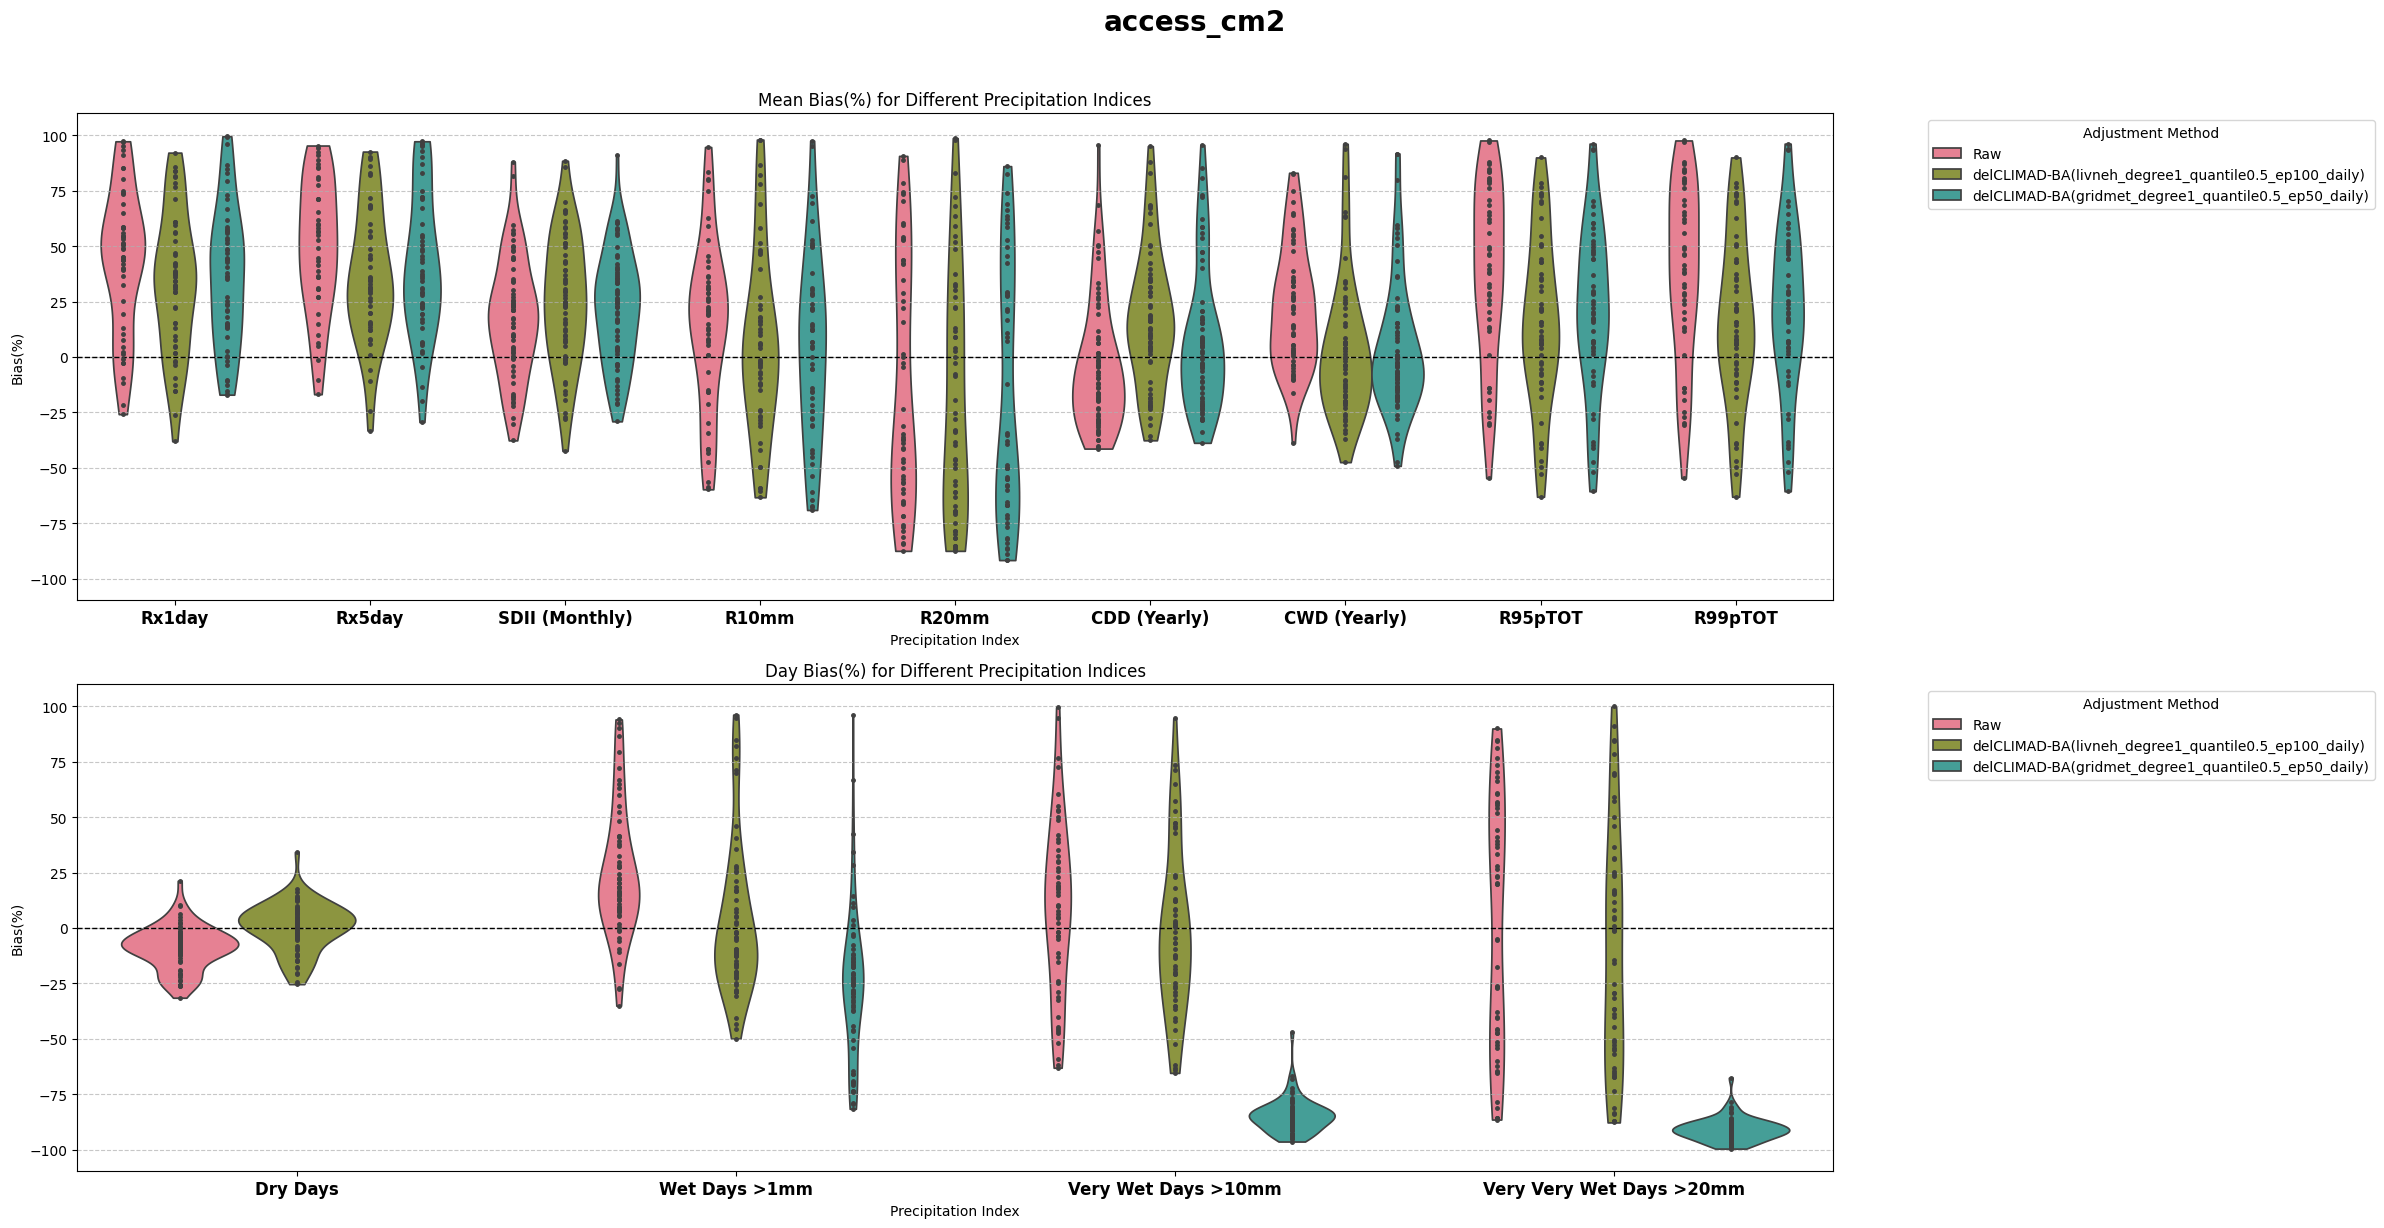

In [91]:
keys = ['SDII (Monthly)','CDD (Yearly)', 'CWD (Yearly)', "Rx1day", "Rx5day", "R10mm",  "R20mm", "R95pTOT", "R99pTOT"]
d = dict(filter(lambda item: item[0] in keys , mean_bias_percentages.items()))

keys = ["Dry Days", "Wet Days >1mm", "Very Wet Days >10mm", "Very Very Wet Days >20mm"]
d4 = dict(filter(lambda item: item[0] in keys , day_bias_percentages.items()))

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 1, figsize=(24, 12), sharey=True)

# Ensure axes is flattened for easy indexing
axes = axes.flatten()
method_names = [f"delCLIMAD-BA({ref}_degree{degree}_quantile{emph_quantile}_ep{testep}_{time_scale})",
                f"delCLIMAD-BA({ref1}_degree{degree1}_quantile{emph_quantile1}_ep{testep1}_{time_scale1})", 
                 "LOCA"]


# Call the function for each dataset
plot_violin_bias(axes[0], d, "Bias(%)", "Mean Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)

plot_violin_bias(axes[1], d4, "Bias(%)", "Day Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)
fig.suptitle(f'{clim}', fontsize=20, fontweight="bold", y=1.02)


plt.tight_layout()
plt.show()

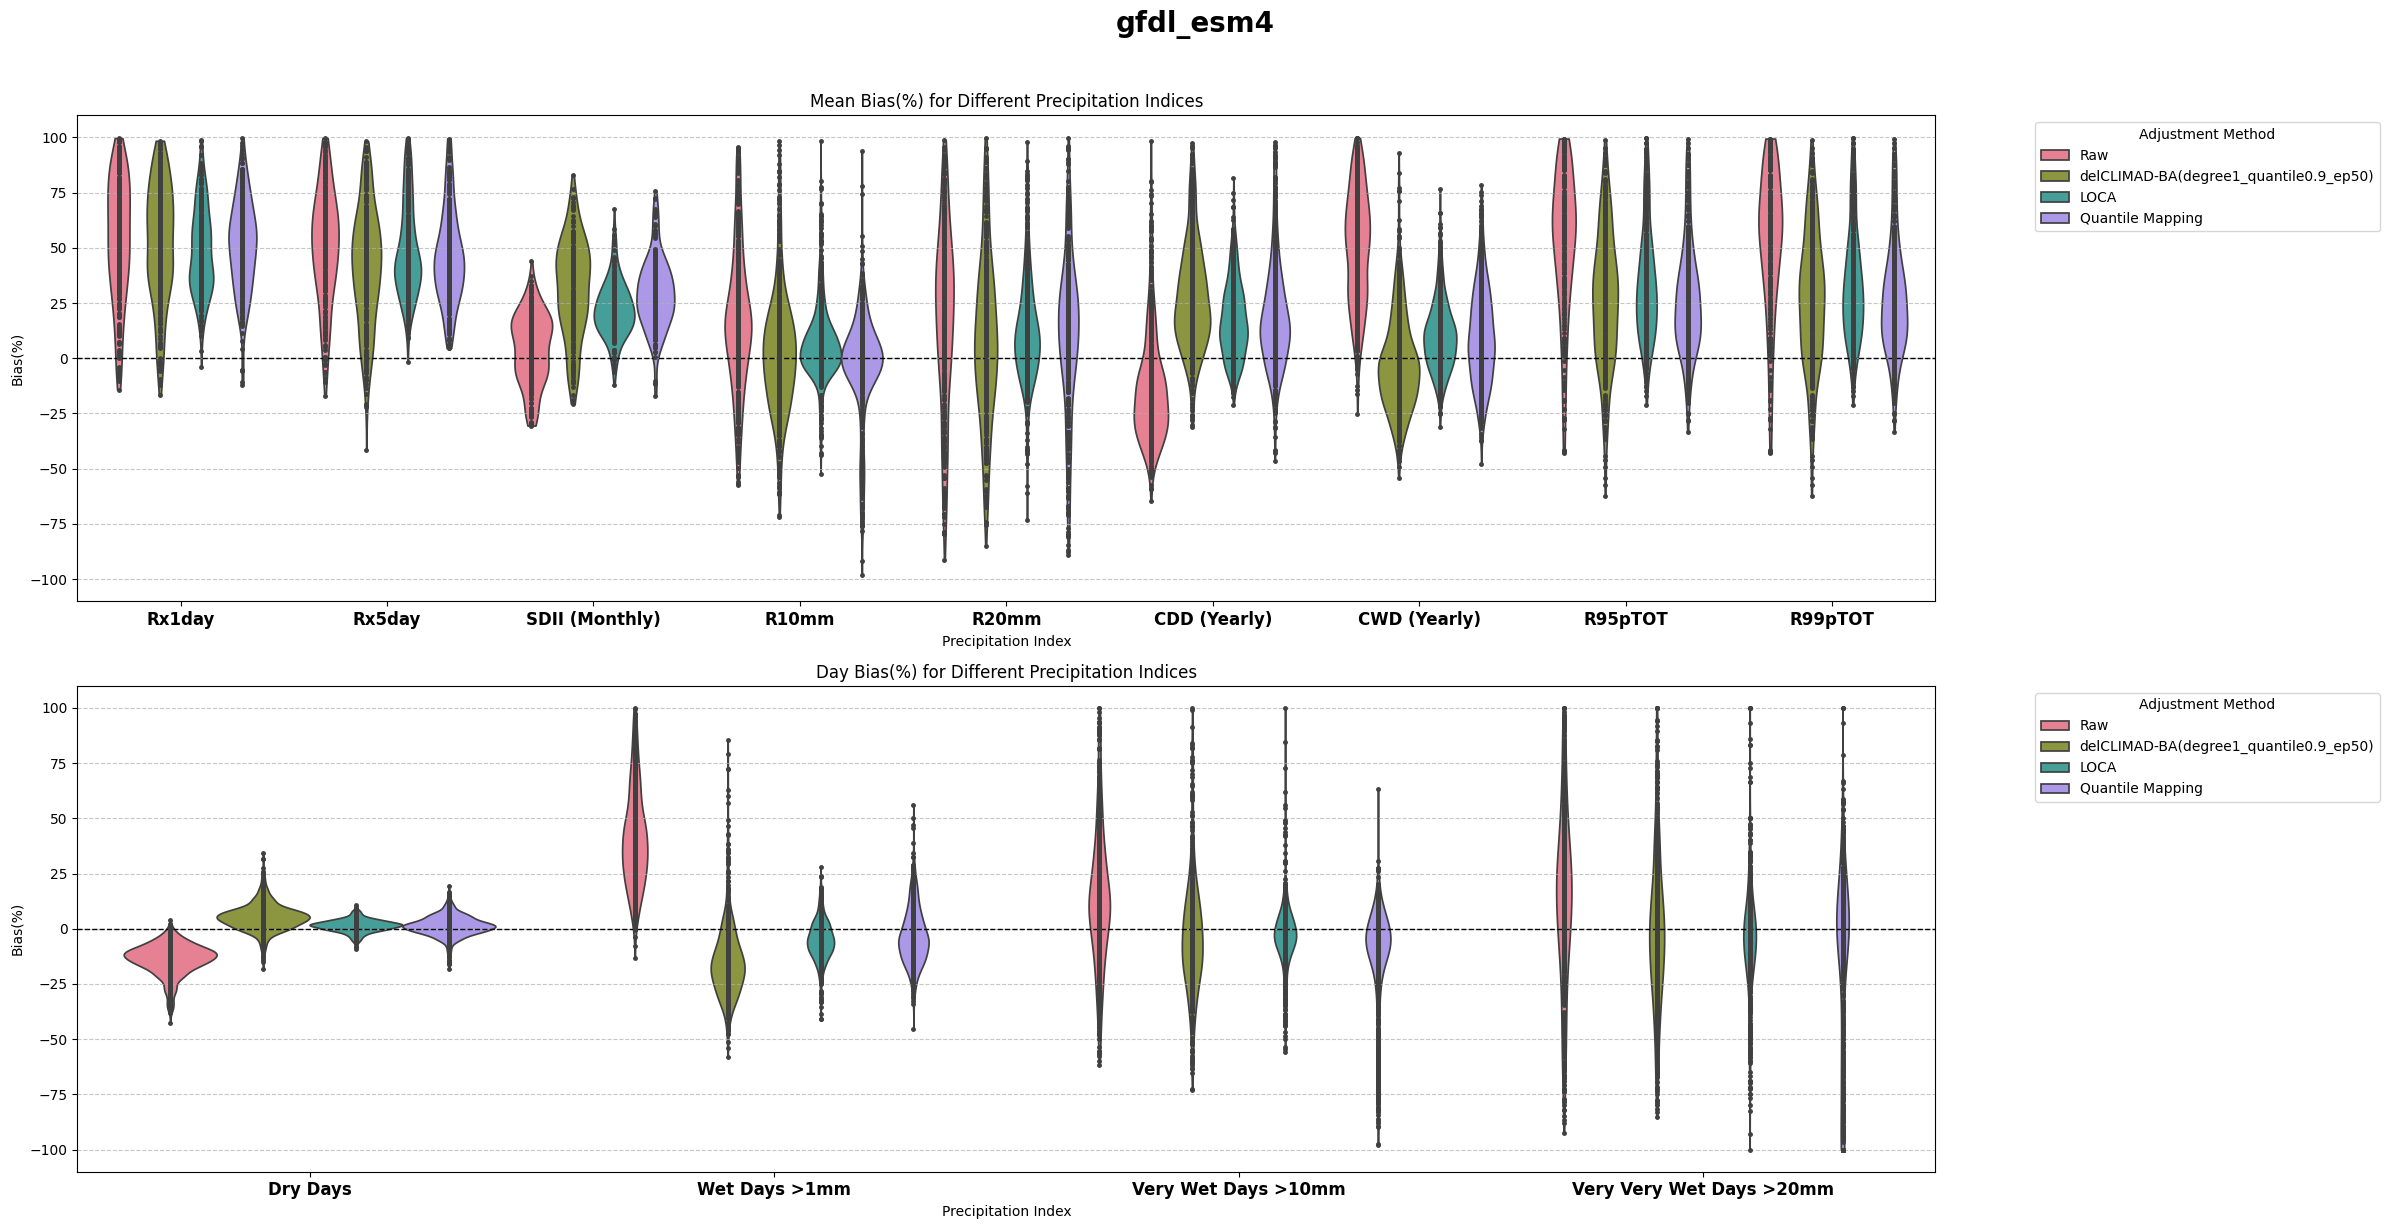

In [111]:
keys = ['SDII (Monthly)','CDD (Yearly)', 'CWD (Yearly)', "Rx1day", "Rx5day", "R10mm",  "R20mm", "R95pTOT", "R99pTOT"]
d = dict(filter(lambda item: item[0] in keys , mean_bias_percentages.items()))

keys = ["Dry Days", "Wet Days >1mm", "Very Wet Days >10mm", "Very Very Wet Days >20mm"]
d4 = dict(filter(lambda item: item[0] in keys , day_bias_percentages.items()))

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 1, figsize=(24, 12), sharey=True)

# Ensure axes is flattened for easy indexing
axes = axes.flatten()
method_names = [f"delCLIMAD-BA(degree{degree}_quantile{emph_quantile}_ep{testep})", "LOCA", "Quantile Mapping"]


# Call the function for each dataset
plot_violin_bias(axes[0], d, "Bias(%)", "Mean Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)

plot_violin_bias(axes[1], d4, "Bias(%)", "Day Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)
fig.suptitle(f'{clim}', fontsize=20, fontweight="bold", y=1.02)


plt.tight_layout()
plt.show()

## Spatial Analysis

In [ ]:
threshold_types = ["Dry Days", "Wet Days >1mm", "Very Wet Days >10mm", "Very Very Wet Days >20mm"]
method_names = ["delCLIMAD-BA", "LOCA"]

plot_spatial_bias(valid_coords=valid_coords,
                         bias_data_dict=day_bias_percentages,
                         threshold_types=threshold_types,
                         label="Bias Days %",
                         method_names=method_names,
                         vmin=-100,
                         vmax=100,
                         cmap="coolwarm")

In [ ]:
threshold_types = ['SDII (Monthly)','CDD (Yearly)', 'CWD (Yearly)', "Rx1day", "Rx5day", "R10mm",  "R20mm", "R95pTOT", "R99pTOT"]
method_names = ["delCLIMAD-BA", "LOCA"]

plot_spatial_bias(valid_coords=valid_coords,
                         bias_data_dict=mean_bias_percentages,
                         threshold_types=threshold_types,
                         label="Mean Bias %",
                         method_names=method_names,
                         vmin=-100,
                         vmax=100,
                         cmap="coolwarm")

In [ ]:
# morans_i, p_value = compute_morans_i(mean_biases['Very Wet Days >10mm'][1], valid_coords)
# plot_moran_scatter(mean_biases['Very Wet Days >10mm'][1], valid_coords)


## Seasonal Analysis

In [ ]:
for season in ['Spring', 'Winter', 'Autumn', 'Summer']:
    x_s_s = x_s[season]
    y_s_s = y_s[season]
    xt_s_s = xt_s[season]
    loca_s_s = loca_s[season]
    t_s_s = t_s[season]

    seasonal_day_bias_percentages = get_day_bias_percentages(x_s_s, y_s_s, xt_s_s, climate_indices)
    seasonal_mean_bias_percentages = get_mean_bias_percentages(x_s_s, y_s_s, xt_s_s, t_s_s, climate_indices)
    seasonal_loca_day_bias_percentages = get_day_bias_percentages(x_s_s, y_s_s, loca_s_s, climate_indices)
    seasonal_loca_mean_bias_percentages = get_mean_bias_percentages(x_s_s, y_s_s, loca_s_s, t_s_s, climate_indices)

    ## Arranging delCLIMAD and LOCA in one dictionary
    for key in day_bias_percentages.keys():
        seasonal_day_bias_percentages[key] = seasonal_day_bias_percentages[key] + (seasonal_loca_day_bias_percentages[key][1],)


    for key in mean_bias_percentages.keys():
        seasonal_mean_bias_percentages[key] = seasonal_mean_bias_percentages[key] + (seasonal_loca_mean_bias_percentages[key][1],)



    keys = ['SDII (Monthly)','CDD (Yearly)', 'CWD (Yearly)', "Rx1day", "Rx5day", "R10mm",  "R20mm", "R95pTOT", "R99pTOT"]
    d = dict(filter(lambda item: item[0] in keys , seasonal_mean_bias_percentages.items()))

    keys = ["Dry Days", "Wet Days >1mm", "Very Wet Days >10mm", "Very Very Wet Days >20mm"]
    d2 = dict(filter(lambda item: item[0] in keys , seasonal_day_bias_percentages.items()))

    # Create a 2x2 subplot figure
    fig, axes = plt.subplots(2, 1, figsize=(24, 12), sharey=True)

    # Ensure axes is flattened for easy indexing
    axes = axes.flatten()
    method_names = [f"delCLIMAD-BA(degree{degree}_quantile{emph_quantile})", "LOCA"]


    # Call the function for each dataset
    plot_violin_bias(axes[0], d, "Bias(%)", f"Mean Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)

    plot_violin_bias(axes[1], d2, "Bias(%)", f"Day Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)
    fig.suptitle(f'{clim}_{season}', fontsize=20, fontweight="bold", y=1.02)


    plt.tight_layout()
    plt.show()

In [ ]:
# Spring
season = 'Spring'
x_s_s = x_s[season]
y_s_s = y_s[season]
xt_s_s = xt_s[season]
loca_s_s = loca_s[season]
t_s_s = t_s[season]

seasonal_day_bias_percentages = get_day_bias_percentages(x_s_s, y_s_s, xt_s_s, climate_indices)
seasonal_mean_bias_percentages = get_mean_bias_percentages(x_s_s, y_s_s, xt_s_s, t_s_s, climate_indices)
seasonal_loca_day_bias_percentages = get_day_bias_percentages(x_s_s, y_s_s, loca_s_s, climate_indices)
seasonal_loca_mean_bias_percentages = get_mean_bias_percentages(x_s_s, y_s_s, loca_s_s, t_s_s, climate_indices)


## Arranging delCLIMAD and LOCA in one dictionary
for key in day_bias_percentages.keys():
    seasonal_day_bias_percentages[key] = seasonal_day_bias_percentages[key] + (seasonal_loca_day_bias_percentages[key][1],)


for key in mean_bias_percentages.keys():
    seasonal_mean_bias_percentages[key] = seasonal_mean_bias_percentages[key] + (seasonal_loca_mean_bias_percentages[key][1],)



keys = ['SDII (Monthly)','CDD (Yearly)', 'CWD (Yearly)', "Rx1day", "Rx5day", "R10mm",  "R20mm", "R95pTOT", "R99pTOT"]
d = dict(filter(lambda item: item[0] in keys , seasonal_mean_bias_percentages.items()))

keys = ["Dry Days", "Wet Days >1mm", "Very Wet Days >10mm", "Very Very Wet Days >20mm"]
d2 = dict(filter(lambda item: item[0] in keys , seasonal_day_bias_percentages.items()))

# Create a 2x2 subplot figure
fig, axes = plt.subplots(2, 1, figsize=(24, 12), sharey=True)

# Ensure axes is flattened for easy indexing
axes = axes.flatten()
method_names = [f"delCLIMAD-BA(degree{degree}_quantile{emph_quantile})", "LOCA"]


# Call the function for each dataset
plot_violin_bias(axes[0], d, "Bias(%)", f"Mean Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)

plot_violin_bias(axes[1], d2, "Bias(%)", f"Day Bias(%) for Different Precipitation Indices",  method_names=method_names, remove_outlier=True)
fig.suptitle(f'{clim}_{season}', fontsize=20, fontweight="bold", y=1.02)


plt.tight_layout()
plt.show()